In [1]:
%matplotlib inline 

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import model
import model_utils
import preprocessing_utils

#to be put under model.py when I refactor
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(1234)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
batch_size = 12
lr = 0.01

num_timesteps_input = 7 # Default is 30 minutes
num_timesteps_output = 4 # Default is 10 minutes

In [4]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = preprocessing_utils.generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = preprocessing_utils.generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).to(device)

In [5]:
def train(x_input, x_target, batch_size):
    """
    Train function per epoch
    """
    
    stgcn.train()
    
    num_samples = x_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    
    training_loss = []
    
    for i in range(math.ceil(num_samples / batch_size)):

        optimizer.zero_grad()
        
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        #Drop left-overs
        if len(batch) % batch_size != 0:
            continue
        
        x_batch = x_input[batch].to(device = device)
        y_batch = x_target[batch].to(device = device)
        
        out = stgcn(adj_mat, x_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.detach().cpu().numpy())
        
    return sum(training_loss) / len(training_loss)

In [6]:
stgcn = model.Stgcn_Model(nodes_num = adj_mat.shape[0], features_num = training_input.shape[3],
                    input_timesteps = num_timesteps_input, num_output = num_timesteps_output).to(device = device)

optimizer = torch.optim.Adam(stgcn.parameters(), lr = lr)
loss_criterion = nn.MSELoss()

training_loss = []
validation_loss = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    
    pbar.set_description(f"Epoch {epoch}")
    
    loss = train(training_input, training_target, batch_size)
    training_loss.append(loss)

    with torch.no_grad():
        val_loss = model_utils.validate(stgcn, loss_criterion, val_input, val_target, adj_mat, batch_size, device)
        validation_loss.append(val_loss.item())
    
    pbar.set_postfix(training_loss=loss, validation_loss=val_loss.item())
        
    #print("Training Loss: {}".format(loss))
    #print("Validation Loss: {}".format(val_loss))


#For Model saving purposes
stgcn.lr = lr 
stgcn.nodes_num = adj_mat.shape[0]
stgcn.features_num = training_input.shape[3]
stgcn.input_timesteps = num_timesteps_input
stgcn.num_output = num_timesteps_output

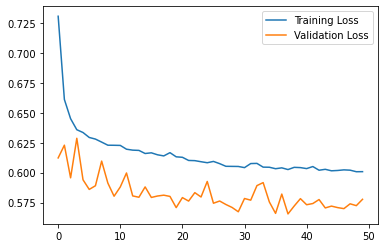

In [7]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [8]:
torch.manual_seed(1234)

with torch.no_grad():
    test_loss = model_utils.validate(stgcn, loss_criterion, test_input, test_target, adj_mat, batch_size, device)
    print(test_loss)

tensor(0.5198)


In [9]:
results = model_utils.predict(stgcn, test_input, batch_size, adj_mat)

In [10]:
print(preprocessing_utils.denormalize(results, stds[0], means[0]))

[[[tensor([[[2.9169, 3.2285, 3.2047, 3.3729],
         [3.5407, 3.7567, 3.6846, 3.6764],
         [4.3996, 4.3450, 4.2538, 4.0490],
         ...,
         [4.2792, 4.4062, 4.6180, 4.5245],
         [3.7983, 3.7803, 3.4794, 3.4308],
         [4.7201, 4.5831, 4.7779, 4.7411]],

        [[2.8258, 3.0680, 3.1268, 3.2544],
         [3.5213, 3.6564, 3.4631, 3.6014],
         [4.3765, 4.2329, 4.1623, 4.2316],
         ...,
         [4.2737, 4.3926, 4.6359, 4.5761],
         [3.6568, 3.7815, 3.5535, 3.4065],
         [4.8123, 4.6824, 4.9133, 4.7388]],

        [[3.2113, 3.2758, 3.2660, 3.3574],
         [3.5754, 3.7239, 3.6478, 3.5843],
         [4.3435, 4.2839, 4.3536, 4.3771],
         ...,
         [4.3306, 4.3658, 4.6601, 4.5885],
         [3.6122, 3.6845, 3.5155, 3.4019],
         [4.7678, 4.6511, 4.7912, 4.6977]],

        ...,

        [[3.1243, 3.2877, 3.1517, 3.2055],
         [3.5643, 3.6847, 3.5576, 3.7570],
         [4.2350, 4.2047, 4.2559, 4.2584],
         ...,
         [4.1348, 

In [11]:
print(preprocessing_utils.denormalize(test_target, stds[0], means[0]))

tensor([[[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.],
         ...,
         [5., 5., 4., 4.],
         [3., 3., 3., 3.],
         [5., 5., 4., 4.]],

        [[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [4., 4., 4., 5.],
         ...,
         [5., 4., 4., 4.],
         [3., 3., 3., 3.],
         [5., 4., 4., 4.]],

        [[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [4., 4., 5., 5.],
         ...,
         [4., 4., 4., 4.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.]],

        ...,

        [[4., 4., 4., 3.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         ...,
         [5., 5., 5., 5.],
         [4., 4., 4., 4.],
         [5., 6., 6., 5.]],

        [[4., 4., 3., 4.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         ...,
         [5., 5., 5., 4.],
         [4., 4., 4., 4.],
         [6., 6., 5., 4.]],

        [[4., 3., 4., 4.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         ...,
 

In [12]:
model_utils.save_model(stgcn,optimizer)

Model has been saved to path : ./saved_models/20210423/20_07_21


In [13]:
loaded_model, loaded_optimizer = model_utils.load_model(path=None)

Loading model in path : ./saved_models/20210423/20_07_21


In [14]:
torch.manual_seed(1234)

#Testing loaded model
loaded_model.to(device)

with torch.no_grad():
    test_loss = model_utils.validate(loaded_model, loss_criterion, test_input, test_target, adj_mat, batch_size, device)
    print(test_loss)

tensor(0.5198)
